# Compare
### A notebook for exploring differences between the provided present and future scenario CESM simulations.
##### Initialized by Drew Camron 03/2018
---

In [1]:
%matplotlib inline
import os

import xarray as xr
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs

sns.set(context='talk')

In [2]:
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:36651 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 72 Cores: 72 Memory: 135.08 GB


Working directories for `pres_indir` and `fut_indir` datasets featuring *present-time* CESM simulations from Jen Kay **without** land/ocean 2CPC discrimination and `pres_lo_indir` and `fut_lo_indir` for the same **with** these discriminations, along with the CloudSat 2CPC gridded observations and CESM GIS mask file.

In [3]:
pres_indir = ('/glade/p/cesm/pcwg_dev/jenkay/COSP/cesm112lens/runs_cesm1_1_2_LENS_n16_cosp1.4_opaq_prec/'+
              'b.e11.BRCP85C5CNBDRD.f09_g16.001_cosp1.4_opaq_prec_goldenrun_agl/')
fut_indir = ('/glade/p/cesm/pcwg_dev/jenkay/COSP/cesm112lens/runs_cesm1_1_2_LENS_n16_cosp1.4_opaq_prec/'+
             'b.e11.BRCP85C5CNBDRD.f09_g16.001_cosp1.4_opaq_prec_goldenrun_future_agl/')

pres_lo_indir = ('/glade/p/cesm/pcwg_dev/jenkay/COSP/cesm112lens/runs_cesm1_1_2_LENS_n16_cosp1.4_opaq_prec/'+
              'b.e11.BRCP85C5CNBDRD.f09_g16.001_cosp1.4_opaq_prec_goldenrun_agl_LANDOCN/')
fut_lo_indir = ('/glade/p/cesm/pcwg_dev/jenkay/COSP/cesm112lens/runs_cesm1_1_2_LENS_n16_cosp1.4_opaq_prec/'+
            'b.e11.BRCP85C5CNBDRD.f09_g16.001_cosp1.4_opaq_prec_goldenrun_future_agl_LANDOCN/')

obs_indir = '/glade/p/work/jenkay/obs/COSP/CLOUDSAT/v2_Tristan/'

mask_indir = '/glade/p/work/lvank/racmo/gismask_RACMO23_0.9x1.25_con.nc'

Here I loop through the observation files to sort by year in `2006-2016` and the months within to read these files in chronologically.

In [4]:
obs_ls = []
for yr in [('%02d' % a) for a in range(6, 17)]:
    for mo in ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']:
        obs_ls = obs_ls + [obs_indir+file for file in os.listdir(obs_indir) if mo+yr in file]

Now I open all of these datasets separately and establish usable pandas timedate indices and map the observation data to their lat-lon grids for easier analysis and plotting.

In [5]:
ds_pres = (xr.open_mfdataset(pres_indir+'b.e11.BRCP85C5CNBDRD.f09_g16.001_cosp1.4_opaq_prec_goldenrun_agl.cam.h0.*.nc', decode_times=False)
          ).sel(lat=slice(0, 90))
ds_fut = (xr.open_mfdataset(fut_indir+'b.e11.BRCP85C5CNBDRD.f09_g16.001_cosp1.4_opaq_prec_goldenrun_future_agl.cam.h0.*.nc', decode_times=False)
         ).sel(lat=slice(0, 90))

ds_lo_pres = (xr.open_mfdataset(pres_lo_indir+'b.e11.BRCP85C5CNBDRD.f09_g16.001_cosp1.4_opaq_prec_goldenrun_agl_LANDOCN.cam.h0.*.nc', decode_times=False)
             ).sel(lat=slice(0, 90))
ds_lo_fut = (xr.open_mfdataset(fut_lo_indir+'b.e11.BRCP85C5CNBDRD.f09_g16.001_cosp1.4_opaq_prec_goldenrun_future_agl_LANDOCN.cam.h0.*.nc', decode_times=False)
            ).sel(lat=slice(0, 90))

ds_obs = xr.open_mfdataset(obs_ls, concat_dim='time')

ms = xr.open_dataarray(mask_indir).sel(lat=slice(0, 90))
ms = ms.where(ms > 0)

ds_pres['time'] = pd.date_range('2011-01', '2021-02', freq='MS')
ds_fut['time'] = pd.date_range('2081-01', '2090-12', freq='MS')
ds_lo_pres['time'] = pd.date_range('2011-01', '2025-12', freq='MS')
ds_lo_fut['time'] = pd.date_range('2081-01', '2095-12', freq='MS')
ds_obs['time'] = pd.date_range('2006-06', '2016-05', freq='MS')

ds_obs['latitude'] = ds_obs['latitude'][0].reset_coords('time', drop=True)
ds_obs['longitude'] = ds_obs['longitude'][0].reset_coords('time', drop=True)
ds_obs = ds_obs.swap_dims({'nlats': 'latitude', 'nlons': 'longitude'}).sel(latitude=slice(0, 90))

For my own reference, here is a list of the full names of variables in the CloudSat observations.

In [6]:
model_vars = ['RADAR_SNOWCERT', 'RADAR_SNOWPOSS', 'RADAR_RAINPROB']
obs_vars = ['snowcounts', 'snowpossiblecounts', 'probablecounts']

### `LANDOCN` data
Now I will begin the task of putting together my analysis of, first up, the `LANDOCN` data of Jen's featuring the land-ocean discriminations of 2CPC in her simulations.

/glade/u/home/mcamron/miniconda3/envs/cesm/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/glade/u/home/mcamron/miniconda3/envs/cesm/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


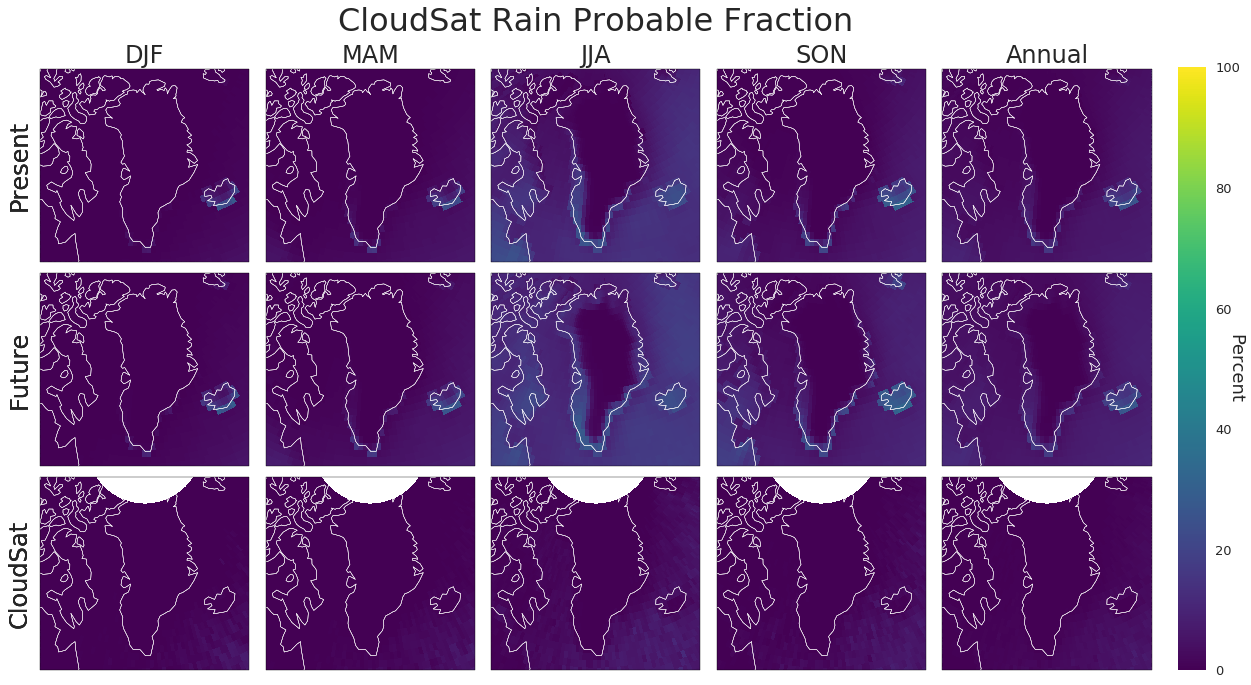

In [7]:
f, axes = plt.subplots(
    nrows=3, ncols=5, figsize=(16, 9),
    subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=315)}
)

for n, var in enumerate(zip(model_vars, obs_vars)):
    for i, x in enumerate(['DJF', 'MAM', 'JJA', 'SON']):
        (ds_lo_pres[var[0]]
         .groupby('time.season')
         .mean('time')
         .sel(season=x)
         .plot.pcolormesh(
             ax=axes[0, i], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
             vmax=100
         )
        )

        (ds_lo_fut[var[0]]
         .groupby('time.season')
         .mean('time')
         .sel(season=x)
         .plot.pcolormesh(
             ax=axes[1, i], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
             vmax=100
         )
        )

        ((ds_obs[var[1]] / ds_obs['counts'] * 100)
         .groupby('time.season')
         .mean('time')
         .sel(season=x)
         .plot.pcolormesh(
             ax=axes[2, i], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
             vmax=100
         )
        )

        axes[0, i].set_title(x, fontsize=24)

    (ds_lo_pres[var[0]]
     .mean('time')
     .plot.pcolormesh(
         ax=axes[0, 4], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False, vmax=100
     )
    )

    (ds_lo_fut[var[0]]
     .mean('time')
     .plot.pcolormesh(
         ax=axes[1, 4], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False, vmax=100
     )
    )

    p = ((ds_obs[var[1]] / ds_obs['counts'] * 100)
         .mean('time')
         .plot.pcolormesh(
             ax=axes[2, 4], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False, vmax=100
         )
        )

    axes[0, 4].set_title('Annual', fontsize=24)

    for ax in axes.flat:
        ax.coastlines(color='white')
        ax.set_extent([290, 340, 55, 85])


    for ax, ylab in zip(axes[:, 0], ['Present', 'Future', 'CloudSat']):
        ax.text(-0.1, 0.5, ylab, rotation='vertical', fontsize=24,
                ha='center', va='center', transform=ax.transAxes)

    f.suptitle(ds_lo_pres[var[0]].long_name, y=1.04, fontsize=32)    

    plt.tight_layout()

    #f.subplots_adjust(right=0.8, hspace=0.0000005, wspace=0.1)
    cb_ax = f.add_axes([1.005, 0.017, 0.025, 0.93])
    cb = f.colorbar(p, cax=cb_ax)
    cb.set_label('Percent', rotation=270, fontsize=18)

    f.savefig('../figures/compare/map_grid_%s_LO.png' % var[0])

Now I want to cumbersomely create the above analysis, but for snow/rain fractions.

Here I will re-create my mean time series for certain outputs for these data.

In [8]:
ms = xr.open_dataarray(mask_indir).sel(lat=slice(0, 90))
ms = ms.where(ms > 0)
w = np.tile((ds_lo_pres['gw'][0]*1.25/360), [len(ds_lo_pres['lon']), 1]).T

In [9]:
ds_lo_pres_w = (ds_lo_pres[[var for var in model_vars]] * ms.values * w).sum('lat').sum('lon') / 2
ds_lo_fut_w = (ds_lo_fut[[var for var in model_vars]] * ms.values * w).sum('lat').sum('lon') / 2

TypeError: not all arguments converted during string formatting

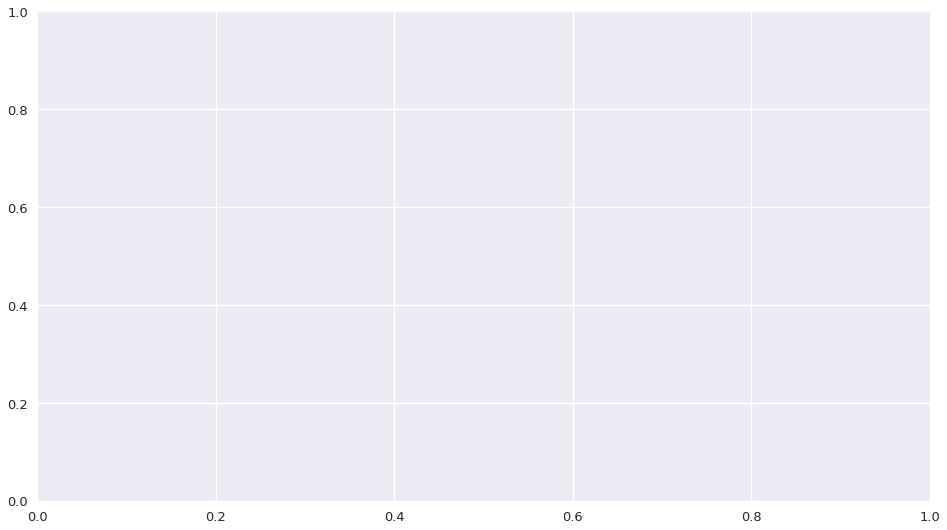

In [10]:
f, ax = plt.subplots(figsize=(16, 9))

for i, x in enumerate(zip(model_vars, obs_vars)):
    (ds_lo_pres_w[x[0]]
     .groupby('time.month').mean('time')
     .plot(ax=ax, label=('%s [pres]' % var), 
           color=sns.color_palette('Dark2', len(model_vars))[i])
    )
    
    (ds_lo_fut_w[x[0]]
     .groupby('time.month').mean('time')
     .plot(ax=ax, label=('%s [fut]' % var), linestyle='dashed',
           color=sns.color_palette('Dark2', len(model_vars))[i])
    )
    
    

In [ ]:
ds_lo_pres['RADAR_SNOWCERT'].groupby('time.month').mean('time')

### Non-`LANDOCN` data